### Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

sns.set(font_scale=0.6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set device to GPU (also do so in Google Colab!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Data preparation

In [ ]:
def concatenate_years(data_vars, years=[2016, 2017], res=64):
  '''
  load tensors for given year and variable and concatenate
  '''
  arr = []
  for year in years:
    tens = torch.load("/content/drive/64/"+data_vars+str(year)+"_" + str(res) + ".pt")
    arr.append(tens)

  return torch.cat(arr, dim=0)

In [ ]:
Y_temp = concatenate_years('Y_temp_', [2016, 2017, 2018], 64)
X_image = concatenate_years('X_image_', [2016, 2017, 2018], 64)

# previously wrong implementation of date tensor; create manually here
df_2016 = pd.read_csv("/content/drive/2016_LA_merged_scaled.csv", delimiter=",")
df_2017 = pd.read_csv("/content/drive/2017_LA_merged_scaled.csv", delimiter=",")
df_2018 = pd.read_csv("/content/drive/2018_LA_merged_scaled.csv", delimiter=",")
df = pd.concat([df_2016, df_2017, df_2018])
X_date = torch.tensor(df[['sin_time', 'cos_time']].values, dtype=torch.float32)

print(X_image.shape)
print(X_date.shape)
print(Y_temp.shape)

torch.Size([12289, 64, 64, 15])
torch.Size([12289, 2])
torch.Size([12289])


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images, dates, labels):
        self.images = images.permute(0, 3, 1, 2)  #(legnth, 15, 64, 64)
        self.dates = dates
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        date = self.dates[idx]
        label = self.labels[idx]
        return image, date, label

In [ ]:
# split data randomly & data loaders
dataset = CustomImageDataset(X_image, X_date, Y_temp)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#### Model training

In [ ]:
def plot_loss(losses, alpha = 0.05):
  plt.figure(figsize=(9, 5))
  # Apply exponential smoothing
  smoothed_losses = []
  smoothed_loss = losses[0]
  for loss in losses:
      smoothed_loss = alpha * loss + (1 - alpha) * smoothed_loss
      smoothed_losses.append(smoothed_loss)

  plt.plot(smoothed_losses)
  plt.xlabel("Batch in Epoch")
  plt.ylabel("Loss")
  plt.grid(True, linestyle="--", color="lightgray")
  plt.show()

In [ ]:
def evaluate_model(model, dataloader):
  model.eval() # Set the model to evaluation mode
  y_true, y_pred = [], []

  with torch.no_grad():
      for data in dataloader:
          x_image = data[0].to(device)
          x_date = data[1].to(device)
          y = data[2].to(device)
          pred = model(x_image, x_date)

          y_true.append(y.cpu().numpy())
          y_pred.append(pred.cpu().numpy())

  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)

  # calculate metrics
  MSE = mean_squared_error(y_true, y_pred)
  MAE = mean_absolute_error(y_true, y_pred)
  R2 = r2_score(y_true, y_pred)

  # plot real agaisnt pred
  plt.scatter(y_true, y_pred)
  plt.xlabel('Real')
  plt.ylabel('Predicted')
  plt.title('Real vs Predicted')
  plt.show()

  # plot hist of real and predicted vals
  plt.hist(y_true, bins=20, alpha=0.5, label='Real', color='blue', density=True)
  plt.hist(y_pred, bins=20, alpha=0.5, label='Predicted', color='red', density=True)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Distribution of Real and Predicted Values')
  plt.legend()
  plt.show()

  model.train() # Set the model back to training mode
  print(f"MSE: {MSE}, MAE: {MAE}, R²: {R2}")
  return MSE, MAE, R2

In [ ]:
class ResNetRegression(nn.Module):
  def __init__(self, time_dim=2):
    super(ResNetRegression, self).__init__()

    # self.resnet = models.resnet34(weights=None) # no weights
    self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # pretrained weights
    self.resnet.conv1 = nn.Conv2d(15, 64, kernel_size=5, stride=1, padding=2, bias=False)

    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 256)

    self.fc1 = nn.Sequential(
        nn.Linear(256 + time_dim, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3)
    )
    self.fc2 = nn.Linear(512, 1)

  def forward(self, x_image, x_time):
    x = self.resnet(x_image)
    x_combined = torch.cat((x, x_time), dim=1)
    x_combined = self.fc1(x_combined)
    x_combined = self.fc2(x_combined)
    return x_combined

In [ ]:
model = ResNetRegression(time_dim=X_date.shape[1])
model = model.to(device)

criterion = nn.HuberLoss(delta=1.0)

# freeze & unfreeze layers
for param in model.resnet.parameters():
  param.requires_grad = False

for param in model.resnet.layer4.parameters():
  param.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.01) # (un)freezing of layers
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

losses = []

best_loss = float('inf')
counter = 0

for epoch in range(200):
  model.train()
  loss_avg = 0
  for data in train_dataloader:
    x_image = data[0].to(device)
    x_date = data[1].to(device)
    y = data[2].to(device).unsqueeze(1)

    optimizer.zero_grad()

    # forward
    y_pred = model(x_image, x_date)
    loss = criterion(y_pred, y)

    # backward
    loss.backward()
    optimizer.step()

    loss_avg += loss.item()
    losses.append(loss.item())

  loss_avg /= len(train_dataloader)

  if epoch % 2 == 0:
    print(f"Epoch: {epoch} - Loss: {loss_avg:.2f}")

  scheduler.step(loss_avg)

  if loss_avg < best_loss:
    best_loss = loss_avg
    counter = 0
    torch.save(model.state_dict(), 'best_model.pth')
  else:
    counter += 1
    if counter >= 7:
      print("stopped early")
      break

Epoch: 0 - Loss: 19.94
Epoch: 2 - Loss: 8.56
Epoch: 4 - Loss: 3.63
Epoch: 6 - Loss: 3.58
Epoch: 8 - Loss: 3.54
Epoch: 10 - Loss: 3.48
Epoch: 12 - Loss: 3.50
Epoch: 14 - Loss: 3.47
Epoch: 16 - Loss: 3.46
Epoch: 18 - Loss: 3.43
Epoch: 20 - Loss: 3.46
Epoch: 22 - Loss: 3.42
Epoch: 24 - Loss: 3.41
Epoch: 26 - Loss: 3.40
Epoch: 28 - Loss: 3.42
Epoch: 30 - Loss: 3.41
Epoch: 32 - Loss: 3.41
Epoch: 34 - Loss: 3.40
Epoch: 36 - Loss: 3.38
Epoch: 38 - Loss: 3.38
Epoch: 40 - Loss: 3.39
Epoch: 42 - Loss: 3.39
Epoch: 44 - Loss: 3.38
Epoch: 46 - Loss: 3.38
Epoch: 48 - Loss: 3.40
Epoch: 50 - Loss: 3.38
Epoch: 52 - Loss: 3.38
Epoch: 54 - Loss: 3.38
stopped early


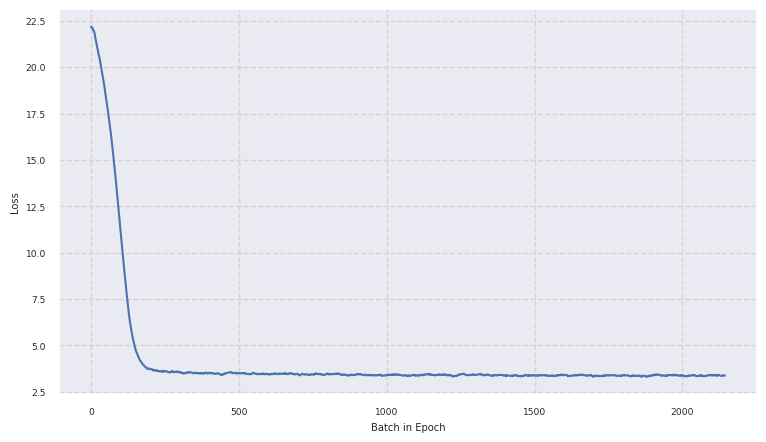

In [ ]:
plot_loss(losses)

<ipython-input-94-bfe4634c9192>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


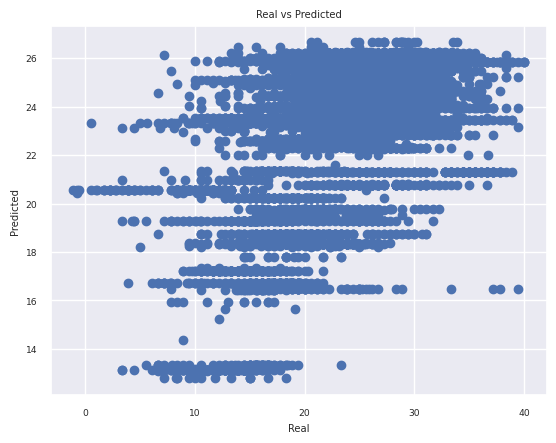

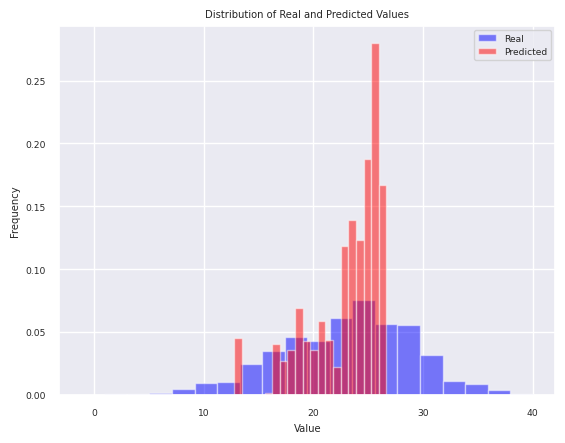

MSE: 25.112585067749023, MAE: 3.7729651927948, R²: 0.32077574729919434


(25.112585067749023, 3.7729651927948, 0.32077574729919434)

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))

evaluate_model(model, train_dataloader)

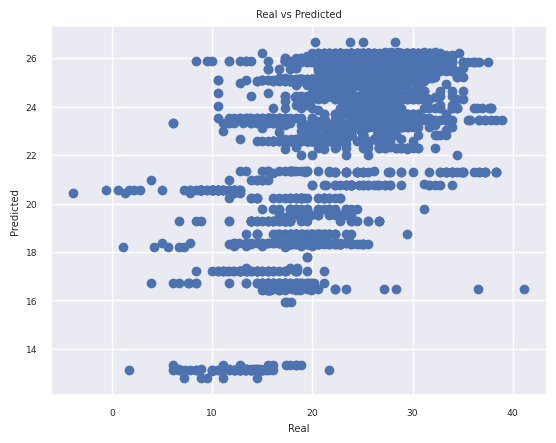

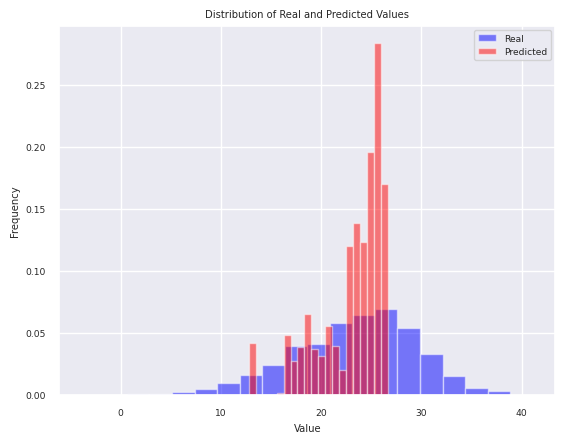

MSE: 25.321819305419922, MAE: 3.7624547481536865, R²: 0.3406825065612793


(25.321819305419922, 3.7624547481536865, 0.3406825065612793)

In [ ]:
evaluate_model(model, test_dataloader)